# Visualizing details of the goal misgeneralization nets
Let's understand lots of details about [the goal misgeneralization paper](https://arxiv.org/abs/2105.14111). In particular, we'll be looking at the cheese-maze task from the goal misgeneralization task, for which cheese was spawned in the 5x5 top-right corner of the maze. 

Key conclusions:
1. Convolutional layers limit speed of information propagation (_locality_). More precisely, ignoring the effect of `maxpool2D` layers, any portions of the state separated by `n` pixels take at least `n/2` convolutional layers to interact.
2. In the maximal maze size of 64 x 64, there is at most **two** steps of computation involving information from e.g. opposite corners of the maze. 

In [17]:
# %% Don't have to restart kernel and reimport each time you modify a dependency
%reload_ext autoreload
%autoreload 2

# %%
# Imports
from typing import List, Tuple, Dict, Union, Optional, Callable
import re 

import numpy as np
import pandas as pd
import torch as t
import plotly.express as px
import plotly as py
import plotly.graph_objects as go
from tqdm import tqdm
from einops import rearrange
from IPython.display import Video, display, clear_output, IFrame
from ipywidgets import *
import itertools
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
import matplotlib.pyplot as plt

# Install procgen tools if needed
try:
  import procgen_tools
except ImportError:
  get_ipython().run_line_magic(magic_name='pip', line='install git+https://github.com/ulissemini/procgen-tools')

In [18]:
# Download data and create directory structure

import os, sys
from pathlib import Path
from procgen_tools.utils import setup

setup() # create directory structure and download data

# path this notebook expects to be in
if 'experiments' not in os.getcwd():
    Path('experiments').mkdir(exist_ok=True)
    os.chdir('experiments')

Already downloaded https://nerdsniper.net/mats/episode_data.tgz
Already downloaded https://nerdsniper.net/mats/data.tgz
Already downloaded https://nerdsniper.net/mats/model_rand_region_5.pth


In [19]:
import circrl.module_hook as cmh
import procgen_tools.models as models
from experiments.patch_utils import *

from procgen import ProcgenGym3Env

RAND_REGION = 5
NUM_ACTIONS = 15
try:
    get_ipython()
    in_jupyter = True
except NameError:
    in_jupyter = False
PATH_PREFIX = '../' if in_jupyter else ''

# %%
# Load model
model_path = PATH_PREFIX + f'trained_models/maze_I/model_rand_region_{RAND_REGION}.pth'
policy = models.load_policy(model_path, NUM_ACTIONS, t.device('cpu'))
hook = cmh.ModuleHook(policy)

In [20]:
# There's a bug in hiddenlayer atm
# import hiddenlayer as hl
# model = models.InterpretableImpalaModel(in_channels=3)
# hl.build_graph(model, t.zeros((1,3, 64, 64), dtype=t.float32))

from torchviz import make_dot
model = models.InterpretableImpalaModel(in_channels=3)
yhat = model(t.zeros((1,3, 64, 64), dtype=t.float32))
dot = make_dot(yhat, params=dict(list(model.named_parameters()))).render('model_graph', format='png') 

dot = make_dot(yhat, params=dict(list(model.named_parameters())))
# Load and imshow the png
from IPython.display import Image
# display(Image('model_graph.png'))

# Delete the files 
import os
os.remove('model_graph.png')
os.remove('model_graph')

In [21]:
# # Now use torchview
# from torchview import draw_graph

# # device='meta' -> no memory is consumed for visualization
# model_graph = draw_graph(model, input_size=(1,3, 64, 64), device='meta')
# model_graph.visual_graph

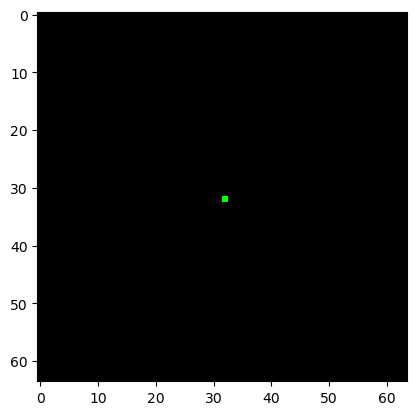

In [22]:
def dummy_obs_pair(color: str, location: Tuple[int, int]=(32,32)):
    """ Returns a mostly-black image pair, the first of which contains a red/green/blue pixel in the center. Returns obs of shape (2, 3, 64, 64). """
    
    assert color in ['R', 'G', 'B'], f'Color must be one of R, G, B, not {color}'
    assert len(location) == 2, 'Location must be a tuple of length 2'
    assert all(0 <= col < 64 for col in location), 'Location must be in [0, 64)'

    channel = {'R': 0, 'G': 1, 'B': 2}[color]
    obs = np.zeros((2, 3, 64, 64), dtype=np.float32)
    obs[0, channel, location[0], location[1]] = 1 # Have one pixel in the middle, in the given channel
    return obs
    
# Let's load a dummy observation with only one nonzero value
plt.imshow(dummy_obs_pair("G")[0].transpose(1,2,0))

In [23]:
# Get the available labels
hook.run_with_input(dummy_obs_pair('R'))
labels = list(hook.values_by_label.keys())[:-1] # Skip the "_out" layer
print(labels)

['embedder.block1.conv_in0', 'embedder.block1.conv_out', 'embedder.block1.maxpool_out', 'embedder.block1.res1.relu1_out', 'embedder.block1.res1.conv1_out', 'embedder.block1.res1.relu2_out', 'embedder.block1.res1.conv2_out', 'embedder.block1.res1.resadd_out', 'embedder.block1.res2.relu1_out', 'embedder.block1.res2.conv1_out', 'embedder.block1.res2.relu2_out', 'embedder.block1.res2.conv2_out', 'embedder.block1.res2.resadd_out', 'embedder.block2.conv_out', 'embedder.block2.maxpool_out', 'embedder.block2.res1.relu1_out', 'embedder.block2.res1.conv1_out', 'embedder.block2.res1.relu2_out', 'embedder.block2.res1.conv2_out', 'embedder.block2.res1.resadd_out', 'embedder.block2.res2.relu1_out', 'embedder.block2.res2.conv1_out', 'embedder.block2.res2.relu2_out', 'embedder.block2.res2.conv2_out', 'embedder.block2.res2.resadd_out', 'embedder.block3.conv_out', 'embedder.block3.maxpool_out', 'embedder.block3.res1.relu1_out', 'embedder.block3.res1.conv1_out', 'embedder.block3.res1.relu2_out', 'embedde

In [24]:
# Let's visualize the activations at each layer using plotly, using an interactive interface that lets us slide the R/G/B pixel around
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

def get_activations(label: str, obs: np.ndarray):
    hook.run_with_input(obs) # Run the model with the given obs
    return hook.get_value_by_label(label) # Shape is (b, c, h, w) at conv layers, (b, activations) at linear layers

def activation_diff(label: str, obs: np.ndarray):
    assert obs.shape[0] == 2 # Must be a pair of observations
    
    activations = get_activations(label, obs)
    return activations[0] - activations[1] # Subtract in order to cancel out bias terms which don't behave differently in the presence of the differing inputs 

def plot_activations(activations: np.ndarray, fig: go.FigureWidget):
    """ Plot the activations given a single (non-batched) activation tensor. """
    fig.update(data=[go.Heatmap(z=activations)])

In [25]:
# Now let's turn the above into a class. We want to be able to call the plotter with a single function call, and have it update the plot automatically.
class ActivationsPlotter:
    def __init__(self, labels: List[str], plotter: Callable, activ_gen: Callable, hook, coords_enabled: bool=False, **act_kwargs):
        """
        labels: The labels of the layers to plot
        plotter: A function that takes a label, channel, and activations and plots them
        activ_gen: A function that takes a label and obs and returns the activations which should be sent to plotter 
        hook: The hook that contains the activations
        coords_enabled: Whether to enable the row and column sliders
        act_kwargs: Keyword arguments to pass to the activations generator
        """
        self.fig = go.FigureWidget()

        self.plotter = plotter
        self.activ_gen = activ_gen
        self.act_kwargs = act_kwargs
        self.hook = hook

        self.label_widget = Dropdown(options=labels, value=labels[0], description="Activations")
        self.channel_slider = IntSlider(min=0, max=127, step=1, value=0, description="Channel")
        self.widgets = [self.fig, self.label_widget, self.channel_slider]

        self.coords_enabled = coords_enabled
        if coords_enabled:
            self.col_slider, self.row_slider = (IntSlider(min=0, max=62, step=1, value=32, description="Column"), IntSlider(min=0, max=63, step=1, value=32, description="Row"))
            self.widgets.extend([self.col_slider, self.row_slider])

        self.filename_widget = Text(value="", placeholder="Custom filename", disabled=False)
        self.filename_widget.layout.width = '150px'

        self.button = Button(description="Save image")
        self.button.on_click(self.save_image)
        self.widgets.append(HBox([self.filename_widget, self.button]))

        for widget in self.widgets:
            if widget != self.fig:
                widget.observe(self.update_plotter, names='value')
        self.update_plotter()

    def display(self):
        """ Display the elements; this function separates functionality from implementation. """
        display(self.fig)
        display(VBox(self.widgets[1:-1])) # Show a VBox of the label dropdown and the sliders, centered beneath the plot
        display(self.widgets[-1])

    def save_image(self, b): # Add a save button to save the image
        basename = self.filename_widget.value if self.filename_widget.value != "" else f"{self.label_widget.value}_{self.channel_slider.value}{f'_{self.col_slider.value}_{self.row_slider.value}' if self.coords_enabled else ''}"
        filepath = f"{PATH_PREFIX}experiments/visualizations/{basename}.png"

        self.fig.write_image(filepath)
        print(f"Saved image to {filepath}")
        
        self.filename_widget.value = "" # Clear the filename_widget box

    def update_plotter(self, b=None):
        """ Update the plot with the current values of the widgets. """
        label, channel = self.label_widget.value, self.channel_slider.value
        if self.coords_enabled:
            col, row = self.col_slider.value, self.row_slider.value
            activations = self.activ_gen(row, col, label, **self.act_kwargs)
        else:
            activations = self.activ_gen(label, **self.act_kwargs)

        shap = self.hook.get_value_by_label(label).shape
        self.channel_slider.max = shap[1] - 1 if len(shap) > 2 else 0
        self.channel_slider.value = min(channel, self.channel_slider.max)
        self.fig.update_layout(height=500, width=500, title_text=label)

        if len(activations.shape) == 1: # Linear layer
            # Unsqueeze the np.ndarray
            activations = np.expand_dims(activations, axis=(0,1))
            # If there's only a single channel, display a 1D Heatmap, with a single rowvalue and the activation indices as the col values TODO remove columns
            new_data = go.Heatmap(y=activations[channel], x=np.arange(activations.shape[2]))
        else: 
            assert channel < activations.shape[0], "Channel doesn't exist at this layer"
            new_data = go.Heatmap(z=activations[channel])

        self.fig.update_layout(height=500, width=500, title_text=label)
        if label == 'fc_policy_out':
            # Transform each index into the corresponding action label, according to maze.py 
            self.fig.update_xaxes(ticktext=[models.human_readable_action(i).title() for i in range(NUM_ACTIONS)], tickvals=np.arange(activations.shape[2]))
        else: # Reset the indices so that there are no xticks
            self.fig.update_xaxes(ticktext=[], tickvals=[])

        self.fig.update_xaxes(side="top") # Set the x ticks to the top
        self.fig.update_yaxes(autorange="reversed") # Reverse the row-axis autorange
        
        self.plotter(activations=activations[channel], fig=self.fig) # Plot the activations TODO fix this call for batches

        # Set the min and max to be the min and max of all channels at this label
        bounds = np.abs(activations).max()
        self.fig.update_traces(zmin=-1 * bounds, zmid=0, zmax=bounds)    
        
        # Change the colorscale to split red (negative) -- white (zero) -- blue (positive)
        self.fig.update_traces(colorscale='RdBu')

In [26]:
# We can begin to see how information propagates across the net for a dummy single-pixel input
def activ_gen_px(col: int, row: int, label: str, color: str, pair: bool = False):
    """ Get the activations for running a forward pass on a dummy observation, in the given color. """
    pair_acts = get_activations(label, dummy_obs_pair(color, (row, col)))
    return pair_acts if pair else pair_acts[0]

# Instantiate the plotter
activ_plotter = ActivationsPlotter(labels, plot_activations, activ_gen_px, hook, coords_enabled=True, color="R")
activ_plotter.display()

FigureWidget({
    'data': [{'colorscale': [[0.0, 'rgb(103,0,31)'], [0.1, 'rgb(178,24,43)'],
                             [0.2, 'rgb(214,96,77)'], [0.3, 'rgb(244,165,130)'],
                             [0.4, 'rgb(253,219,199)'], [0.5, 'rgb(247,247,247)'],
                             [0.6, 'rgb(209,229,240)'], [0.7, 'rgb(146,197,222)'],
                             [0.8, 'rgb(67,147,195)'], [0.9, 'rgb(33,102,172)'],
                             [1.0, 'rgb(5,48,97)']],
              'type': 'heatmap',
              'uid': '629f2953-5e36-4540-9a5e-26aa2b4bc5f3',
              'z': array([[0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          ...,
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
              'zmax': 1.0,
              '

In [27]:
def plot_nonzero_activations(activations: np.ndarray, fig: go.FigureWidget):
    """ Plot the nonzero activations in a heatmap. """
    # Find nonzero activations and cast to floats
    nz = (activations != 0).astype(np.float32)
    fig.update(data=[go.Heatmap(z=nz)])

def plot_nonzero_diffs(activations: np.ndarray, fig: go.FigureWidget):
    """ Plot the nonzero activation diffs in a heatmap. """
    diffs = activations[0] - activations[1]
    print(activations.shape)
    plot_nonzero_activations(diffs, fig)

# Instantiate the plotter
nonzero_plotter = ActivationsPlotter(labels, plotter=plot_nonzero_diffs, activ_gen=activ_gen_px, hook=hook, coords_enabled=True, color="R", pair=True)
nonzero_plotter.display()

(3, 64, 64)


FigureWidget({
    'data': [{'colorscale': [[0.0, 'rgb(103,0,31)'], [0.1, 'rgb(178,24,43)'],
                             [0.2, 'rgb(214,96,77)'], [0.3, 'rgb(244,165,130)'],
                             [0.4, 'rgb(253,219,199)'], [0.5, 'rgb(247,247,247)'],
                             [0.6, 'rgb(209,229,240)'], [0.7, 'rgb(146,197,222)'],
                             [0.8, 'rgb(67,147,195)'], [0.9, 'rgb(33,102,172)'],
                             [1.0, 'rgb(5,48,97)']],
              'type': 'heatmap',
              'uid': 'db300743-3595-4cf0-a34b-5eef76434aa9',
              'z': array([[0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          ...,
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
              'zmax': 1.0,
              '

# 1: Locality
Consider `n` convolutional layers (3x3 kernel, stride=1, padding=1) which each preserve the height col width of the previous feature maps. The above demonstrates that after these layers, information can only propagate `n` L1 pixels. The network itself is composed of # TODO 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The difference between the two images is:


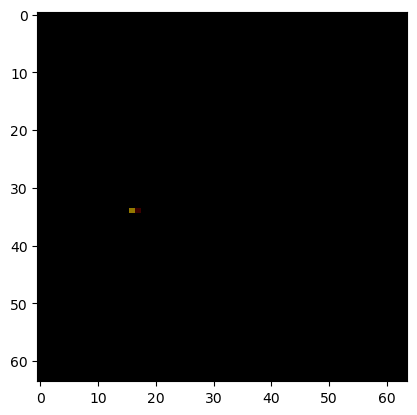

In [28]:
# Load up a cheese/no-cheese maze pair 
from experiments.patch_utils import *

seed = 0
venv = get_cheese_venv_pair(seed=seed)
obs = venv.reset()
obs = np.array(obs, dtype=np.float32)

# Show the diff of the RGB renders
print("The difference between the two images is:")
plt.imshow(rearrange(obs[0]-obs[1], 'c h w -> h w c'))

In [29]:
# Visualize the activations for this pair
cheese_diff_plotter = ActivationsPlotter(labels, plot_activations, lambda label: activation_diff(label, obs), hook)
cheese_diff_plotter.display()

FigureWidget({
    'data': [{'colorscale': [[0.0, 'rgb(103,0,31)'], [0.1, 'rgb(178,24,43)'],
                             [0.2, 'rgb(214,96,77)'], [0.3, 'rgb(244,165,130)'],
                             [0.4, 'rgb(253,219,199)'], [0.5, 'rgb(247,247,247)'],
                             [0.6, 'rgb(209,229,240)'], [0.7, 'rgb(146,197,222)'],
                             [0.8, 'rgb(67,147,195)'], [0.9, 'rgb(33,102,172)'],
                             [1.0, 'rgb(5,48,97)']],
              'type': 'heatmap',
              'uid': '0e604e25-6250-4eed-8be3-798118b299fc',
              'z': array([[0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          ...,
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
              'zmax': 0.5764706,
         

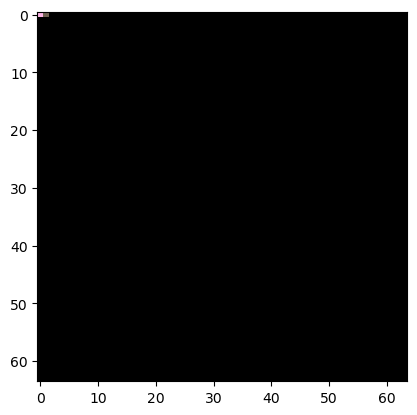

In [30]:
cheese_pixels = obs[0][(obs[0]-obs[1]) != 0] # Get the nonzero pixels
cheese_pixels = [(cheese_pixels[i], cheese_pixels[i+1], cheese_pixels[i+2]) for i in range(0, len(cheese_pixels), 3)] # Split into (R,G,B) tuples

def show_cheese_at(col: int, row: int):
    """ Make an all-black image with cheese at the given location. """
    obs = np.zeros((3,64,64), dtype=np.float32)
    obs[:, row, col] = cheese_pixels[0]
    obs[:, row, col+1] = cheese_pixels[1]
    return obs

plt.imshow(rearrange(show_cheese_at(0,0), 'c h w -> h w c')) # Show the cheese at the top left corner

In [31]:
def activ_gen_cheese(col: int, row: int, label: str):
    """ Return the activations for an observation with cheese at the given location. """
    cheese_obs = show_cheese_at(col,row)
    cheese_obs = rearrange(cheese_obs, 'c h w -> 1 c h w')
    activations = get_activations(label, cheese_obs)
    return activations[0]

moving_cheese_plotter = ActivationsPlotter(labels, plot_activations, activ_gen_cheese, hook, coords_enabled=True)
moving_cheese_plotter.display()

FigureWidget({
    'data': [{'colorscale': [[0.0, 'rgb(103,0,31)'], [0.1, 'rgb(178,24,43)'],
                             [0.2, 'rgb(214,96,77)'], [0.3, 'rgb(244,165,130)'],
                             [0.4, 'rgb(253,219,199)'], [0.5, 'rgb(247,247,247)'],
                             [0.6, 'rgb(209,229,240)'], [0.7, 'rgb(146,197,222)'],
                             [0.8, 'rgb(67,147,195)'], [0.9, 'rgb(33,102,172)'],
                             [1.0, 'rgb(5,48,97)']],
              'type': 'heatmap',
              'uid': '128501b7-09d7-4f4e-97e8-5548df790d4f',
              'z': array([[0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          ...,
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
              'zmax': 0.99607843,
        

# Visualizing actual observation activations

In [37]:
venv = create_venv(num=1, start_level=0, num_levels=1)

def activ_gen_cheese(label: str):
    """ Generate an observation with cheese at the given location. """
    cheese_obs = venv.reset()
    cheese_obs = np.array(cheese_obs, dtype=np.float32)
    return get_activations(label, cheese_obs)[0] # Take the first and only batch element

# Show a maze editor side-by-side with the interactive plotter
custom_maze_plotter = ActivationsPlotter(labels, plot_activations, activ_gen_cheese, hook)

editors = maze.venv_editors(venv, check_on_dist=False, env_nums=range(1), callback=lambda _: custom_maze_plotter.update_plotter())
display(HBox(editors))

custom_maze_plotter.display()

FigureWidget({
    'data': [{'colorscale': [[0.0, 'rgb(103,0,31)'], [0.1, 'rgb(178,24,43)'],
                             [0.2, 'rgb(214,96,77)'], [0.3, 'rgb(244,165,130)'],
                             [0.4, 'rgb(253,219,199)'], [0.5, 'rgb(247,247,247)'],
                             [0.6, 'rgb(209,229,240)'], [0.7, 'rgb(146,197,222)'],
                             [0.8, 'rgb(67,147,195)'], [0.9, 'rgb(33,102,172)'],
                             [1.0, 'rgb(5,48,97)']],
              'type': 'heatmap',
              'uid': '22be833c-94f3-41ac-9956-52da7bcc4383',
              'z': array([[0.7411765 , 0.77254903, 0.77254903, ..., 0.7411765 , 0.7411765 ,
                           0.77254903],
                          [0.7882353 , 0.7411765 , 0.7411765 , ..., 0.7411765 , 0.7882353 ,
                           0.7411765 ],
                          [0.7882353 , 0.7882353 , 0.7882353 , ..., 0.7882353 , 0.7882353 ,
                           0.7882353 ],
                          ...,
     